 <table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:300%;">
        Regression Project
    </h1></td>
    <td width="25%">
    <div style="text-align: right">
    <b> Machine Learning 2022</b> <br>
    <b>Project 1 
</tr>
</table>

The aim of this project is to predict the burned area by forest fires in the northeast region of Portugal, fitting a regression model.  Weather and temporal variables were used in addition to fire index condintion data inherent to fire ignition, spread and intensity.

The dataset contains:
- 517 instances, one for each forest fire registered
- 12 variables
- 1 outcome, represented by the area burned.

The variables contain information about localization of the fire (2), temporal variables (2), weather variables (4), fuel code indexes (3) and fire velocity spread score (1).

# Workflow 
- Data visualization
- Preliminary analysis
- Linear regression
- Polynomial regression with cross-validation
- Feature selection with cross-validation

We first import the packages which are necessary to perform the analysis.

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import scipy
import statsmodels.api as sm


np.random.seed(0)

# Data Visualization and Assessment

1. We load the csv dataset and visualize the dataframe.
2. Not available data are filled with the string "Missing", we then proceed to replace the latter string with nan. 

In [2]:
ff_data = pd.read_csv("forestfires.csv")
ff_data.head()

ff_data.replace('Missing', np.nan, inplace=True)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9,8.3,97,4,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


Temporal variables i.e. month and day, are categorical. We proceed to replace them with numerical data. We will thus obtain continuous numerical variables.
The variable month will have values from 0 to 11.
The variable day will be considered with a different logic, since we have to take into account that during the holidays there may be a higher number of visitors. We thus assigned value 0 to working days and value 1 to weekend days.

In [3]:
mapping = {'mon': 0, 'tue': 0, 'wed':0, 'thu':0, 'fri':0, 'sat':1, 'sun':1}
ff_data.replace({'day': mapping}, inplace=True)

mapping11 = {'jan': 0, 'feb': 1, 'mar':2, 'apr':3, 'may':4, 'jun':5, 'jul':6, 'aug': 7, 'sep': 8, 'oct':9, 'nov':10, 'dec':11}
ff_data.replace({'month': mapping11}, inplace=True)

ff_data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,2,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,9,0,90.6,35.4,669.1,6.7,18,33,0.9,0.0,0.0
2,7,4,9,1,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,2,0,91.7,33.3,77.5,9,8.3,97,4,0.2,0.0
4,8,6,2,1,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


We print information on index dtypes, columns, and non-null values.

In [4]:
ff_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    int64  
 3   day     517 non-null    int64  
 4   FFMC    516 non-null    object 
 5   DMC     517 non-null    float64
 6   DC      516 non-null    object 
 7   ISI     515 non-null    object 
 8   temp    515 non-null    object 
 9   RH      517 non-null    int64  
 10  wind    516 non-null    object 
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(3), int64(5), object(5)
memory usage: 52.6+ KB


The dataframe contains 517 entries and 13 variables of which 12 predictors and the area outcome.
Null variables are detected, we proceed sum them.
Dtypes of the variables are not the same, we will proceed later to uniform them.

In [5]:
print(ff_data.isnull().sum())

X        0
Y        0
month    0
day      0
FFMC     1
DMC      0
DC       1
ISI      2
temp     2
RH       0
wind     1
rain     0
area     0
dtype: int64


Missing values are very few compared to the n data cases, so we can safely remove them and perform training on the remaining samples.

In [6]:
forest_data = ff_data.dropna()
print(forest_data.isnull().sum())

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64


We now convert object variables to float32 variables and plot multiple histograms to check the distribution of our variables.

array([[<AxesSubplot:title={'center':'X'}>,
        <AxesSubplot:title={'center':'Y'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'day'}>],
       [<AxesSubplot:title={'center':'FFMC'}>,
        <AxesSubplot:title={'center':'DMC'}>,
        <AxesSubplot:title={'center':'DC'}>,
        <AxesSubplot:title={'center':'ISI'}>],
       [<AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'RH'}>,
        <AxesSubplot:title={'center':'wind'}>,
        <AxesSubplot:title={'center':'rain'}>],
       [<AxesSubplot:title={'center':'area'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

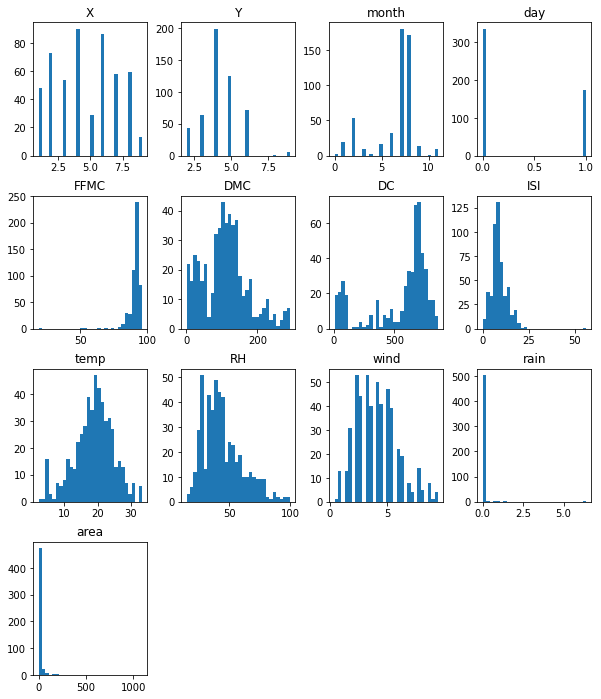

In [7]:
forest_data = forest_data.astype(np.float32)
forest_data.hist(grid=False,
       figsize=(10, 12),
       bins=30)

Variables rain and area are strongly right skewed toward zero. The FFMC variable is left skewed. We now quantify the skewedness and the kurtosis of each variable.

In [8]:
forest_data.agg(['skew', 'kurtosis']).transpose()

,skew,kurtosis
X,0.045490,-1.168781
Y,0.417180,1.435509
month,-1.214422,0.636990
day,0.671972,-1.554566
FFMC,-6.544838,66.340469
DMC,0.546849,0.211169
DC,-1.097583,-0.255635
ISI,2.549528,21.534243
temp,-0.330697,0.129587
RH,0.858355,0.427177


As we anticipated, variables area, rain and FFMC are heavily skewed.

From the histograms, we also noticed that variables area and rain seem to have high frequencies of zero-values. We proceed to count them and compute the respective variances.

In [9]:
print("The sum of zero-values for variable rain:",(forest_data['rain'] == 0.0).sum())
print("The sum of zero-values for the output area:", (forest_data['area'] == 0.0).sum())
print("The variance of rain variable:", forest_data.var()['rain'])
print("The variance of the output area", forest_data.var()['area'])

The sum of zero-values for variable rain: 502
The sum of zero-values for the output area: 240
The variance of rain variable: 0.08878985
The variance of the output area 4105.49


The rain variable has a very low variance with only 1.56% of the data containing a non-zero rain level. This variable will be removed from the model.

The outcome variable has to be log transformed as log(area+1) due to the presence of zeros.
We then proceed to plot the histogram of the transformed variable to assess any improvement of the distribution.

In [10]:
forest_data.insert(len(ff_data.columns), "log_area",
         np.log1p(ff_data["area"]))

array([[<AxesSubplot:title={'center':'area'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'log_area'}>]], dtype=object)

240

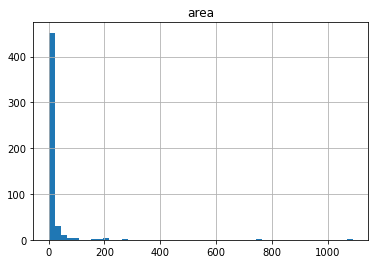

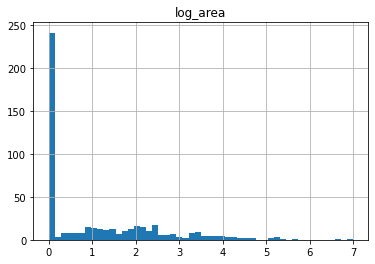

In [11]:
forest_data.hist(column = "area", bins=50)
forest_data.hist(column = "log_area", bins=50)

(forest_data['log_area'] == 0.0).sum()

We can assess that the skew has been reduced by the log(area+1) transformation.

The variable FFMC is left-skewed. We proceeded to perform common transformations (e.g. cube and square power, log) and we will report below only the best one i.e. 

In [12]:
forest_data.insert(len(forest_data.columns), 'FFMC_cube',
                   (np.power(forest_data['FFMC'],3)))

,skew,kurtosis
X,0.045490,-1.168781
Y,0.417180,1.435509
month,-1.214422,0.636990
day,0.671972,-1.554566
FFMC,-6.544838,66.340469
DMC,0.546849,0.211169
DC,-1.097583,-0.255635
ISI,2.549528,21.534243
temp,-0.330697,0.129587
RH,0.858355,0.427177


array([[<AxesSubplot:title={'center':'FFMC'}>]], dtype=object)

array([[<AxesSubplot:title={'center':'FFMC_cube'}>]], dtype=object)

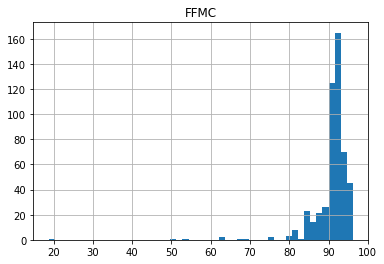

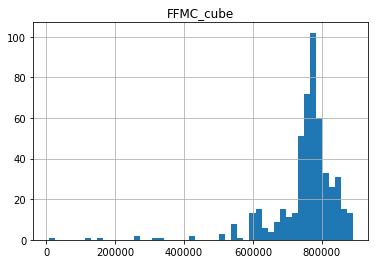

In [13]:
forest_data.agg(['skew', 'kurtosis']).transpose()
forest_data.hist(column = "FFMC", bins=50)
forest_data.hist(column = "FFMC_cube", bins=50)

From the histogram and from the computation of skew and kurtosis we can see an improvement in the distribution of the variable FFMC.

For better interpretation, we rename the variable day as weekend, and remove the variables we previously transformed.

In [14]:
forest_data.rename(columns = {'day': "weekend"}, inplace = True)

In [15]:
forest_data.drop('FFMC' , inplace=True, axis=1)

In [16]:
forest_data.drop('area' , inplace=True, axis=1)

To assess evental correlations between variables, we compute a correlation table.

In [17]:
corr = forest_data.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/var/folders/66/9jfzllnx3p30h2fff0s29spm0000gn/T/ipykernel_94213/762743979.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,X,Y,month,weekend,DMC,DC,ISI,temp,RH,wind,rain,log_area,FFMC_cube
X,1.00,0.54,-0.07,-0.02,-0.05,-0.09,0.01,-0.05,0.09,0.02,0.07,0.07,-0.04
Y,0.54,1.00,-0.07,0.00,0.00,-0.10,-0.03,-0.03,0.06,-0.02,0.03,0.04,-0.05
month,-0.07,-0.07,1.00,-0.06,0.47,0.87,0.18,0.37,-0.09,-0.08,0.01,0.12,0.33
weekend,-0.02,0.00,-0.06,1.00,0.01,-0.03,-0.03,0.04,0.10,-0.04,-0.04,0.04,-0.08
DMC,-0.05,0.00,0.47,0.01,1.00,0.68,0.31,0.47,0.07,-0.11,0.08,0.07,0.46
DC,-0.09,-0.10,0.87,-0.03,0.68,1.00,0.23,0.49,-0.04,-0.20,0.04,0.07,0.40
ISI,0.01,-0.03,0.18,-0.03,0.31,0.23,1.00,0.39,-0.13,0.11,0.07,-0.01,0.64
temp,-0.05,-0.03,0.37,0.04,0.47,0.49,0.39,1.00,-0.53,-0.22,0.07,0.06,0.52
RH,0.09,0.06,-0.09,0.10,0.07,-0.04,-0.13,-0.53,1.00,0.07,0.10,-0.06,-0.31
wind,0.02,-0.02,-0.08,-0.04,-0.11,-0.20,0.11,-0.22,0.07,1.00,0.06,0.07,-0.06


From the table we can see:
- ISI, temp, DMC, DC, FFMC_cube positively correlated
- X and Y positevely correlated
- Rh and temp negatively correlated
- The outcome variable log_area doesn't seem to be correlated with any single variable

We will take this information into account when fitting linear regression.

In [18]:
X_features = ['X', 'Y', 'FFMC_cube', 'DMC',"DC","ISI", "temp","RH", "wind", "rain", "month", "weekend"]
X = forest_data[X_features].to_numpy()  
y = forest_data['log_area'].to_numpy()    
print("X.shape", X.shape, "X.dtype", X.dtype)
print("y.shape", y.shape, "y.dtype", y.dtype)

X.shape (510, 12) X.dtype float32
y.shape (510,) y.dtype float64


In [19]:
from sklearn.linear_model import LinearRegression
model= LinearRegression(fit_intercept=True)
model.fit(X,y)
y_predict=model.predict(X)

LinearRegression()

In [20]:
from sklearn.metrics import r2_score, mean_squared_error
print("R2 score ", r2_score(y, y_predict))
print("MSE score ", mean_squared_error(y, y_predict))

R2 score  0.04405122415365703
MSE score  1.8750509492999017


In [21]:
print("X.shape", X.shape, "X.dtype", X.dtype)
print("y.shape", y.shape, "y.dtype", y.dtype)

X.shape (510, 12) X.dtype float32
y.shape (510,) y.dtype float64


# Preliminar Exploratory Analysis

In this part of the project we aim to explore some data assessement. 
In the previous part, we detected outliers and a high proportion of zero-values.
We will perform linear regression first with all the variables and the original dataset comprising all the zero-values, and the linear regression with all the variables but with zero-values removed.
After fitting these models, we will plot the respective Q-Q plots to monitor the residuals.

### First model: 12 variables and original dataset

In [22]:
import statsmodels.formula.api as smf
model = smf.ols("log_area ~ X + Y + FFMC_cube + DMC + DC + ISI+ rain + temp + RH + wind + month + weekend ", data= forest_data).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_area   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     1.909
Date:                Wed, 11 May 2022   Prob (F-statistic):             0.0312
Time:                        10:33:39   Log-Likelihood:                -883.96
No. Observations:                 510   AIC:                             1794.
Df Residuals:                     497   BIC:                             1849.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1070      0.824      0.130      0.897      -1.511       1.725
X              0.0505      0.032      1.586      0.113      -0.012       0.113
Y             -0.0063      0.060     -0.104      0.917      -0.125       0.112
FFMC_cube   3.141e-07   9.44e-07      0.333      0.740   -1.54e-06    2.17e-06
DMC            0.0025      0.002      1.604      0.109      -0.001       0.006
DC            -0.0012      0.001     -1.710      0.088      -0.003       0.000
ISI           -0.0252      0.018     -1.368      0.172      -0.061       0.011
rain           0.0894      0.212      0.422      0.673      -0.327       0.506
temp           0.0044      0.018      0.249      0.804      -0.030       0.039
RH            -0.0054      0.005     -1.025      0.306      -0.016       0.005
wind           0.0631      0.037      1.686      0.092      -0.010       0.137
month          0.1589      0.061      2.620      0.009       0.040       0.278
weekend        0.1686      0.133      1.272      0.204      -0.092       0.429
==============================================================================
Omnibus:                       80.027   Durbin-Watson:                   0.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.676
Skew:                           1.111   Prob(JB):                     1.25e-25
Kurtosis:                       3.678   Cond. No.                     1.02e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the summary we can assess that the only significant variable is month with a coefficient of 0.1589 and a p-value of 0.040. All the other variables seem to be non significant and can't provide information on the outcome.

((array([-2.99813447e+00, -2.71671576e+00, -2.55851315e+00, -2.44635586e+00,
         -2.35848680e+00, -2.28575874e+00, -2.22342522e+00, -2.16869425e+00,
         -2.11977922e+00, -2.07546529e+00, -2.03488747e+00, -1.99740725e+00,
         -1.96253934e+00, -1.92990598e+00, -1.89920709e+00, -1.87020024e+00,
         -1.84268661e+00, -1.81650106e+00, -1.79150490e+00, -1.76758043e+00,
         -1.74462689e+00, -1.72255736e+00, -1.70129629e+00, -1.68077756e+00,
         -1.66094301e+00, -1.64174116e+00, -1.62312624e+00, -1.60505735e+00,
         -1.58749778e+00, -1.57041449e+00, -1.55377759e+00, -1.53755997e+00,
         -1.52173695e+00, -1.50628601e+00, -1.49118651e+00, -1.47641955e+00,
         -1.46196770e+00, -1.44781490e+00, -1.43394629e+00, -1.42034814e+00,
         -1.40700766e+00, -1.39391299e+00, -1.38105306e+00, -1.36841756e+00,
         -1.35599684e+00, -1.34378186e+00, -1.33176415e+00, -1.31993576e+00,
         -1.30828922e+00, -1.29681748e+00, -1.28551391e+00, -1.27437225e+00,

Text(0.5, 1.0, 'Model1 Residuals Q-Q Plot')

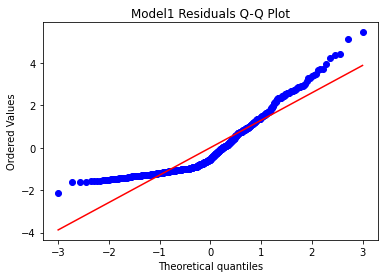

In [23]:
from scipy import stats
stats.probplot(model.resid, dist="norm", plot= plt)
plt.title("Model1 Residuals Q-Q Plot")

The Q-Q plot shows a non-proportionality of the residuals and very heavy tails.

### Second model: 12 variables and reduced dataset.

In [24]:
forest_data_z = forest_data.loc[~((forest_data['log_area'] == 0))]
import statsmodels.formula.api as smf
model2 = smf.ols("log_area ~ X + Y + FFMC_cube + DMC + DC + ISI + rain + temp + RH + wind + month + weekend ", data= forest_data_z).fit()

model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               log_area   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.331
Date:                Wed, 11 May 2022   Prob (F-statistic):              0.201
Time:                        10:33:39   Log-Likelihood:                -436.31
No. Observations:                 270   AIC:                             898.6
Df Residuals:                     257   BIC:                             945.4
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2187      1.286      1.725      0.086      -0.314       4.751
X              0.0427      0.038      1.124      0.262      -0.032       0.117
Y             -0.0834      0.078     -1.070      0.286      -0.237       0.070
FFMC_cube   3.695e-07   1.64e-06      0.226      0.822   -2.85e-06    3.59e-06
DMC            0.0038      0.002      1.921      0.056   -9.48e-05       0.008
DC            -0.0013      0.001     -1.556      0.121      -0.003       0.000
ISI           -0.0393      0.030     -1.310      0.191      -0.098       0.020
rain           0.0680      0.197      0.345      0.731      -0.320       0.456
temp          -0.0055      0.022     -0.255      0.799      -0.048       0.037
RH            -0.0094      0.007     -1.356      0.176      -0.023       0.004
wind           0.0281      0.047      0.598      0.550      -0.065       0.121
month          0.1122      0.072      1.549      0.123      -0.030       0.255
weekend        0.3456      0.168      2.052      0.041       0.014       0.677
==============================================================================
Omnibus:                       26.785   Durbin-Watson:                   0.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.655
Skew:                           0.796   Prob(JB):                     1.34e-07
Kurtosis:                       3.531   Cond. No.                     1.29e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

((array([-2.79889136, -2.49923605, -2.32929308, -2.20804764, -2.11256101,
         -2.03316588, -1.96483642, -1.90461157, -1.85059397, -1.80149182,
         -1.75638435, -1.71459116, -1.67559465, -1.63899153, -1.6044612 ,
         -1.57174441, -1.54062842, -1.51093641, -1.48251972, -1.45525215,
         -1.4290256 , -1.40374673, -1.37933435, -1.35571742, -1.33283334,
         -1.31062671, -1.28904824, -1.26805384, -1.24760395, -1.2276629 ,
         -1.20819843, -1.18918124, -1.17058467, -1.15238435, -1.13455796,
         -1.117085  , -1.0999466 , -1.08312533, -1.06660508, -1.05037092,
         -1.03440896, -1.01870629, -1.00325087, -0.98803146, -0.97303753,
         -0.95825923, -0.94368731, -0.92931306, -0.91512831, -0.90112534,
         -0.88729687, -0.87363603, -0.86013631, -0.84679156, -0.83359593,
         -0.82054388, -0.80763013, -0.79484969, -0.78219778, -0.76966986,
         -0.75726158, -0.74496882, -0.73278761, -0.72071418, -0.70874491,
         -0.69687632, -0.68510509, -0.

Text(0.5, 1.0, 'Model2 Residuals Q-Q Plot')

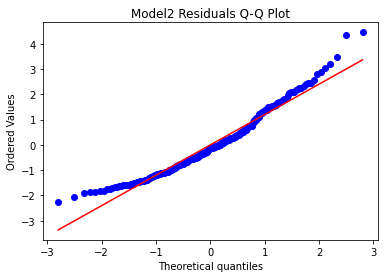

In [25]:
stats.probplot(model2.resid, dist="norm", plot= plt)
plt.title("Model2 Residuals Q-Q Plot")

The Q-Q plot has slightly improved. However, the tails are still heavy.
The improvement doesn't seem to justify such a depletion of the dataset. Thus, we will perform our analysis with the complete dataset.

# Linear Regression

We now proceed to perform a multivariate linear regression to predict a quantitative response i.e. the burned area.
We also aim to find which variables influence the most the outcome.

We will first create a variable to assess whether a month is considered hot or cold, to further implement a stratification.

In [26]:
forest_data['hot_cold'] = 1
forest_data['hot_cold'] = forest_data['month'].apply(lambda x: 0 if (x>=3 and x<=9) else 1)
forest_data

,X,Y,month,weekend,DMC,DC,ISI,temp,RH,wind,rain,log_area,FFMC_cube,hot_cold
0,7.0,5.0,2.0,0.0,26.200001,94.300003,5.1,8.200000,51.0,6.7,0.0,0.000000,640503.8750,1
1,7.0,4.0,9.0,0.0,35.400002,669.099976,6.7,18.000000,33.0,0.9,0.0,0.000000,743677.3750,0
2,7.0,4.0,9.0,1.0,43.700001,686.900024,6.7,14.600000,33.0,1.3,0.0,0.000000,743677.3750,0
3,8.0,6.0,2.0,0.0,33.299999,77.500000,9.0,8.300000,97.0,4.0,0.2,0.000000,771095.1250,1
4,8.0,6.0,2.0,1.0,51.299999,102.199997,9.6,11.400000,99.0,1.8,0.0,0.000000,712122.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4.0,3.0,7.0,1.0,56.700001,665.599976,1.9,27.799999,32.0,2.7,0.0,2.006871,543338.4375,0
513,2.0,4.0,7.0,1.0,56.700001,665.599976,1.9,21.900000,71.0,5.8,0.0,4.012592,543338.4375,0
514,7.0,4.0,7.0,1.0,56.700001,665.599976,1.9,21.200001,70.0,6.7,0.0,2.498152,543338.4375,0
515,1.0,4.0,7.0,1.0,146.000000,614.700012,11.3,25.600000,42.0,4.0,0.0,0.000000,841232.4375,0


The stratification is used to mantain the same proportion in the features while dividing the dataset in training and test sets. 

In [27]:
def add_id_stratify(row):
    """
    Add ID for stratification - log_area_weekday_cold
    """
    if 0 <= row['log_area'] < 1:
        id_ = 'area_{}_we{}_cold{}'.format('0', row['weekend'], row['hot_cold'])
    elif 1 <= row['log_area'] < 4:
        id_ = 'area_{}_we{}_cold{}'.format('1', row['weekend'], row['hot_cold'])
    else:
        id_ = 'area_{}_we{}_cold{}'.format('2', row['weekend'], row['hot_cold'])
        
    return id_


forest_data['id_strat'] = forest_data.apply(lambda row: add_id_stratify(row), 1)

forest_data.head()

,X,Y,month,weekend,DMC,DC,ISI,temp,RH,wind,rain,log_area,FFMC_cube,hot_cold,id_strat
0,7.0,5.0,2.0,0.0,26.200001,94.300003,5.1,8.2,51.0,6.7,0.0,0.0,640503.875,1,area_0_we0.0_cold1.0
1,7.0,4.0,9.0,0.0,35.400002,669.099976,6.7,18.0,33.0,0.9,0.0,0.0,743677.375,0,area_0_we0.0_cold0.0
2,7.0,4.0,9.0,1.0,43.700001,686.900024,6.7,14.6,33.0,1.3,0.0,0.0,743677.375,0,area_0_we1.0_cold0.0
3,8.0,6.0,2.0,0.0,33.299999,77.500000,9.0,8.3,97.0,4.0,0.2,0.0,771095.125,1,area_0_we0.0_cold1.0
4,8.0,6.0,2.0,1.0,51.299999,102.199997,9.6,11.4,99.0,1.8,0.0,0.0,712122.000,1,area_0_we1.0_cold1.0


We compute the percentages of the different strata.

In [28]:
forest_data.id_strat.value_counts() / forest_data.id_strat.value_counts().sum()

area_0_we0.0_cold0.0    0.311765
area_1_we0.0_cold0.0    0.215686
area_0_we1.0_cold0.0    0.164706
area_1_we1.0_cold0.0    0.096078
area_0_we0.0_cold1.0    0.066667
area_1_we0.0_cold1.0    0.045098
area_0_we1.0_cold1.0    0.029412
area_1_we1.0_cold1.0    0.025490
area_2_we1.0_cold0.0    0.025490
area_2_we0.0_cold0.0    0.019608
Name: id_strat, dtype: float64

Splitting of the dataset in training and test sets.

In [29]:
from sklearn.model_selection import train_test_split, StratifiedKFold
ff_test_size = 0.15
ff_test_seed = 40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    random_state=42, stratify=forest_data.id_strat)
print("X_train.shape ", X_train.shape)
print("X_test.shape ", X_test.shape)

X_train.shape  (433, 12)
X_test.shape  (77, 12)


We now implement a linear regression with all the features.

In [30]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True) 
model = model.fit(X_train, y_train) 

y_predict_test = model.predict(X_test)
y_predict_train = model.predict(X_train)


print("Train R2 score ", r2_score(y_train, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train, y_predict_train))

print("Test R2 score ", r2_score(y_test, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test, y_predict_test))

Train R2 score  0.052813755548075436
Train MSE score  1.8537083673364043
Test R2 score  -0.27517703314901665
Test MSE score  2.5220424605764733


The R squared and the MSE have worsen from the train test to the test set.

We now reduce our subset of variables. We remove 
- rain as previously specified
- Y as it is correlated with X
- FFMC_cube as strongly correlated with ISI and temp
- DC as highly correlated with DMC and month.

In [31]:
X_reduct = ['X',"DMC","ISI", "temp","RH", "wind", "month","weekend"]
X2 = forest_data[X_reduct].to_numpy()  
y = forest_data['log_area'].to_numpy()    
print("X.shape", X.shape, "X.dtype", X.dtype)
print("y.shape", y.shape, "y.dtype", y.dtype)

ff_test_seed_v2=40
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X2, y,
                                                                test_size=ff_test_size, 
                                                                random_state=ff_test_seed_v2)

model = LinearRegression()                       
model = model.fit(X_train_small, y_train_small)        
y_predict_test = model.predict(X_test_small)     
y_predict_train = model.predict(X_train_small)


print("Train R2 score ", r2_score(y_train_small, y_predict_train))
print("Train MSE score ", mean_squared_error(y_train_small, y_predict_train))

print("Test R2 score ", r2_score(y_test_small, y_predict_test))
print("Test MSE score ", mean_squared_error(y_test_small, y_predict_test))

X.shape (510, 12) X.dtype float32
y.shape (510,) y.dtype float64
Train R2 score  0.04361337773465568
Train MSE score  1.8996421515680484
Test R2 score  -0.013448281712548749
Test MSE score  1.8437101289030537


We don't see an improvement with the reduced model as the R squared is lower than the model with all the features.
The linear regression model however seems not to be the best choice as we can't deal with the strong multicollinearity. Furthermore the variables do not explain the outcome, making the inference impossible to be done.

## Polynomial Regression

An alternative to linear regression is polynomial regression, as the relationship between the outcome and the predictors may be non-linear.
We thus include transformed versions of the predictors in the model.

We assess below which polynomial degree better fits our data. We chose degrees from 1 to 4 and we compute the score and the R squared for each one. The GridSearchCV class performs cross validation while also searching among a set of different hyperparameters.

In [32]:
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
r2_scorer = make_scorer(r2_score,
                        greater_is_better=True)


model = Pipeline([('poly', PolynomialFeatures(degree=1, include_bias=False)),
                  ('linear', LinearRegression(fit_intercept=True))])


parameters = {'poly__degree': list(range(1,5))}

r2_scorer = make_scorer(r2_score,
                        greater_is_better=True)
cv = GridSearchCV(model, parameters, scoring=r2_scorer, cv=5, refit=True)
cv.fit(X_train_small, y_train_small)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=1,
                                                           include_bias=False)),
                                       ('linear', LinearRegression())]),
             param_grid={'poly__degree': [1, 2, 3, 4]},
             scoring=make_scorer(r2_score))

In [33]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002957,0.002277,0.027450,0.053397,1,{'poly__degree': 1},0.030774,0.030800,-0.141170,-0.003265,-0.007925,-0.018157,0.063639,1
1,0.004658,0.004222,0.000749,0.000223,2,{'poly__degree': 2},-0.043337,-0.032514,-0.769964,-0.072185,-0.082910,-0.200182,0.285482,2
2,0.007724,0.003090,0.000955,0.000312,3,{'poly__degree': 3},-1.134155,-119.832933,-1.724926,-2.397118,-0.878388,-25.193504,47.322612,3
3,0.012446,0.000814,0.000948,0.000041,4,{'poly__degree': 4},-4.484430,-5332.759396,-4.381090,-12.951672,-3.228419,-1071.561001,2130.602044,4


We now estimate which degree is the best for the polynomial model.

In [34]:
print("Best model:", cv.best_estimator_)

print("Best polynomial degree:", cv.best_params_)

print("Best cross-validation score:", cv.best_score_)

Best model: Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('linear', LinearRegression())])
Best polynomial degree: {'poly__degree': 1}
Best cross-validation score: -0.018157355311319325


In [35]:
model = cv.best_estimator_
y_predict = model.predict(X_test_small)
test_score = r2_score(y_test_small, y_predict)

print("Best degree:", cv.best_params_['poly__degree'])
print("Train score:", cv.best_score_)
print("Test score:", test_score)

Best degree: 1
Train score: -0.018157355311319325
Test score: -0.013448281712548749


As a result we obtained that the degree that best fits our model is degree 1.
We can say that this result is not improving the linear regression method we implemented before, as non-linear relationships aren't introduced in the new model. In other words we end up with the same model we previously fitted with multi-collinear regression.

# Best Feature Subset Selection

We now consider a way in which the linear model can be improved using other fitting procedures instead of least squares.

With subset selection we aim to identify a subset of the p predictors related to the response and exclude irrelevant variables from a multiple regression model.

In [36]:
X_train_pd = pd.DataFrame(X_train, columns=X_features)
X_test_pd = pd.DataFrame(X_test, columns=X_features)

In [37]:
import itertools
def get_subsets(X_pd, dim):
    feature_names = X_pd.columns.tolist()

    subset_names = itertools.combinations(feature_names, dim)
    data_subsets = [X_pd[list(fnames)] for fnames in subset_names]
    return data_subsets

subsets = get_subsets(X_train_pd, 1)

In [38]:
def get_evaluator(scorer):
    def evaluator(model, X, y, trained=False):
        if not trained:
            model = model.fit(X, y)
        score = scorer(model, X, y)
        return model, score
    return evaluator   

In [39]:
from sklearn.dummy import DummyRegressor

def subset_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                     candidates_evaluator, candidates_argbest, 
                     subsets_evaluator, subsets_argbest,       
                     test_evaluator=None, test_argbest=None, 
                     candidates_scorer_name=None,  
                     subsets_scorer_name=None,     
                     verbose=True, weight_step3=0):  
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    subsets_test = [] 
    subsets_metric = []        
    subsets_best_features = [] 
    plt.figure()
    candidate_fig = plt.subplot(111) 
    num_evaluations = 0      
    
    # 1. and 2. Evaluate all Mk candidates with
    #           k=0...P features
    # =========================================
    for dim in range(num_features+1):
        candidate_metrics = [] 
        candidate_models = []  
        
        # 2.a Fixed the number of features 'dim', look at
        #     all the possible candidate models with that
        #     cardinality
        # ===============================================
        dim_subsets = get_subsets(Xtrain_pd, dim=dim)
        for Xtrain_sub in dim_subsets:
            
            if Xtrain_sub.shape[-1] == 0:
                # 1. Train the M0 model if the number of
                #    features is zero!
                # ======================================
                model = DummyRegressor()
            else:
                model = LinearRegression(fit_intercept=True)
            
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([dim]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate among those using
        #     the same number of features (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
        
        best_features = dim_subsets[idx_best_candidate].columns.tolist()
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        subsets_best_features.append(best_features)
        
        
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = dim_subsets[idx_best_candidate]
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_subset_Xtrain.columns.tolist()]
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        num_evaluations += weight_step3
        
        if verbose:
            print("Best model (M{}) with {} features: {}".format(dim, dim, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    

    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()


We now select the best model among all, using cross-validated predicted error MSE.

Best model (M0) with 0 features: []
M0 subset score (3.): 1.9876057818760864
Best model (M1) with 1 features: ['month']
M1 subset score (3.): 2.0117977018087276
Best model (M2) with 2 features: ['wind', 'month']
M2 subset score (3.): 2.053045877725299
Best model (M3) with 3 features: ['wind', 'month', 'weekend']
M3 subset score (3.): 2.063138515483966
Best model (M4) with 4 features: ['wind', 'rain', 'month', 'weekend']
M4 subset score (3.): 2.7057698798322143
Best model (M5) with 5 features: ['X', 'wind', 'rain', 'month', 'weekend']
M5 subset score (3.): 2.714287289270331
Best model (M6) with 6 features: ['X', 'ISI', 'wind', 'rain', 'month', 'weekend']
M6 subset score (3.): 2.7105092258681314
Best model (M7) with 7 features: ['DMC', 'DC', 'ISI', 'RH', 'wind', 'month', 'weekend']
M7 subset score (3.): 2.031086696033011
Best model (M8) with 8 features: ['X', 'DMC', 'DC', 'ISI', 'RH', 'wind', 'month', 'weekend']
M8 subset score (3.): 1.9880032931967442
Best model (M9) with 9 features: ['

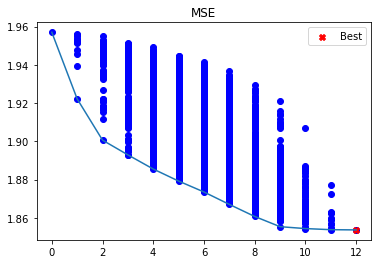

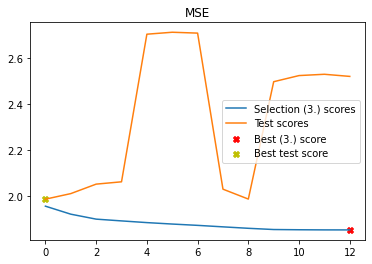

In [40]:
subset_selection(X_train_pd, y_train, X_test_pd, y_test,
                 get_evaluator(make_scorer(mean_squared_error)), np.argmin,
                 get_evaluator(make_scorer(mean_squared_error)), np.argmin,
                 candidates_scorer_name="MSE",
                 subsets_scorer_name="MSE",
                 verbose=True)

The first graph represents the best models for training data, according to Mean Squared Error: the lowest, the better. The model depicted in red is considered to be the best one, that is the one containing all the features.

The second graph represents the evaluation of the best models both for training and test data, again with the use of Mean Squared Error. 
In this case the best model for test data is the one having no features.

For this reason, we proceed the Best Feature Subset Selection by using a different evaluator for the training and test set.

In [41]:
def estimate_sigma(Xtrain_pd, ytrain):
    n, p = Xtrain_pd.shape
    model = LinearRegression(fit_intercept=True)
    model.fit(Xtrain_pd, ytrain)
    y_pred = model.predict(Xtrain_pd)
    RSS = rss(y_pred, ytrain)
    RSE = np.sqrt(RSS / (n-p))
    return RSE

def cp(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / n

def aic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + 2*d*sigma2) / (n*sigma2)

def bic(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    return (rss(y_pred, y_true) + np.log(n)*d*sigma2) / (n*sigma2)

def adj_r2(y_pred, y_true, n, d, sigma):
    sigma2 = sigma**2
    RSS = rss(y_pred, y_true)
    TSS = tss(y_true)
    return 1 - (RSS/(n-d-1)) / (TSS/(n-1))


Best model (M0) with 0 features: []
M0 subset score (3.): 1.9876057818760864
Best model (M1) with 1 features: ['month']
M1 subset score (3.): 2.0117977018087276
Best model (M2) with 2 features: ['wind', 'month']
M2 subset score (3.): 2.053045877725299
Best model (M3) with 3 features: ['wind', 'month', 'weekend']
M3 subset score (3.): 2.063138515483966
Best model (M4) with 4 features: ['wind', 'rain', 'month', 'weekend']
M4 subset score (3.): 2.7057698798322143
Best model (M5) with 5 features: ['X', 'wind', 'rain', 'month', 'weekend']
M5 subset score (3.): 2.714287289270331
Best model (M6) with 6 features: ['X', 'ISI', 'wind', 'rain', 'month', 'weekend']
M6 subset score (3.): 2.7105092258681314
Best model (M7) with 7 features: ['DMC', 'DC', 'ISI', 'RH', 'wind', 'month', 'weekend']
M7 subset score (3.): 2.031086696033011
Best model (M8) with 8 features: ['X', 'DMC', 'DC', 'ISI', 'RH', 'wind', 'month', 'weekend']
M8 subset score (3.): 1.9880032931967442
Best model (M9) with 9 features: ['

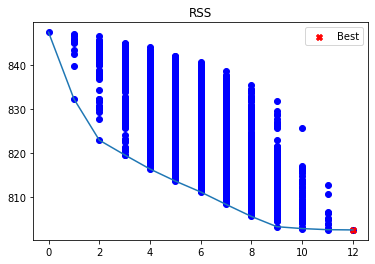

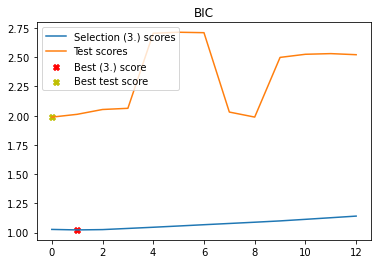

In [42]:
def rss(y_true, y_pred):
  
    y_true = y_true.reshape(y_pred.shape)
    return np.sum((y_true - y_pred) ** 2)

def get_sigma_scorer(metric, sigma):
    def scorer(model, X, y):
        n, d = X.shape
        y_pred = model.predict(X)
        return metric(y_pred, y, n, d, sigma)
    
    return scorer

sigma = estimate_sigma(X_train_pd, y_train)
subset_selection(X_train_pd, y_train, X_test_pd, y_test,
                 get_evaluator(make_scorer(rss)), np.argmin, # 2.
                 get_evaluator(get_sigma_scorer(bic, sigma)), np.argmin, # 3.
                 get_evaluator(make_scorer(mean_squared_error)), np.argmin, # test
                 candidates_scorer_name="RSS",
                 subsets_scorer_name="BIC",
                 verbose=True)

The first graph represents the best model according to Root Sum Squared: the lowest, the better. The model depicted in red is the best one, that is the one containing all the features.

The second graph represents the evaluation of the best models both for training and test data, by using the Bayesian information criterion, which will penalize the choice of best models containing many features. In this case the best model for training data is the one having one feature, that is month. Indeed this feature was found to be the only one significantly correlated with the outcome, in the preliminary analysis. The best model for test data is again the one having no features.

# Forward Feature Selection and Cross-validation

As an alternative to best subset selection, we use an approach that considers a smaller set of models.
It starts with an empty model and adds one predictor at time.
At each step the variable that gives the greatest additional improvement to the fit is added to the model.
We directly estimate the test error using the cross-validated R-squared, by holding out a subset of the training observations from the fitting process and then applying the feature selection to the held out observations.

In [43]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

def forward_selection(Xtrain_pd, ytrain, Xtest_pd, ytest,
                      candidates_evaluator, candidates_argbest, # Metric to be used at 2.b
                      subsets_evaluator, subsets_argbest,       # Metric to be used at 3
                      test_evaluator=None, test_argbest=None,
                      candidates_scorer_name=None,  # Name of 2. figure
                      subsets_scorer_name=None,     # Name of 3. figure
                      verbose=True, weight_step3=0):   
    test_evaluator = subsets_evaluator if not test_evaluator else test_evaluator
    test_argbest = subsets_argbest if not test_argbest else test_argbest
    
    # Global variable init
    # ====================
    num_features = Xtrain_pd.shape[-1]
    best_candidate_metric = []
    subsets_test = []
    subsets_metric = []       
    subsets_best_features = []
    
    plt.figure()
    candidate_fig = plt.subplot(111) 
    num_evaluations = 0        
    
    selected_features = []  
    all_features = Xtrain_pd.columns
    
    
    # 1. Train M0
    # ===========
    model = DummyRegressor()
    
    model, score = candidates_evaluator(model, Xtrain_pd[[]], ytrain)
    best_candidate_metric.append(score)
    subsets_best_features.append([])
    _ = candidate_fig.scatter([0], [score], color="b")
    
    _, score = subsets_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_metric.append(score)
    _, score = test_evaluator(model, Xtrain_pd[[]], ytrain, trained=True)
    subsets_test.append(score)
    
    # 2. Evaluate all Mk candidates with
    #    k=0...P features

    for dim in range(num_features):
        candidate_metrics = [] 
        candidate_models = []  
        
        # 2.a Given the previous Mk model, test remaining
        # features and select the one providing the best
        # performance increment
        # ===============================================
        remaining_features = all_features.difference(selected_features)
        
        for new_column in remaining_features:
            Xtrain_sub = Xtrain_pd[selected_features+[new_column]]
            model = LinearRegression(fit_intercept=True)
            model, score = candidates_evaluator(model, Xtrain_sub, ytrain)
            candidate_models.append(model)
            candidate_metrics.append(score)
            num_evaluations += 1
            
        _ = candidate_fig.scatter([Xtrain_sub.shape[-1]]*len(candidate_metrics), candidate_metrics,
                                  color="b")
            
        # 2.b Select the best candidate in (2.a)
        # ===============================================
        idx_best_candidate = candidates_argbest(candidate_metrics)
       
        selected_features.append(remaining_features[idx_best_candidate])
        
        best_candidate_metric.append(candidate_metrics[idx_best_candidate])
        best_features = selected_features.copy()
        subsets_best_features.append(best_features)
        
        # Compute metric for step 3.
        best_subset_model = candidate_models[idx_best_candidate]
        best_subset_Xtrain = Xtrain_pd[best_features].to_numpy()
        _, score = subsets_evaluator(best_subset_model, best_subset_Xtrain, ytrain, trained=True)
        subsets_metric.append(score)
        best_subset_Xtest = Xtest_pd[best_features].to_numpy()
        _, score = test_evaluator(best_subset_model, best_subset_Xtest, ytest, trained=True)
        subsets_test.append(score)
        num_evaluations += weight_step3 
        
        if verbose:
            print("............")
            print("Best model (M{}) with {} features: {}".format(dim, dim, best_features))
            print("M{} subset score (3.): {}".format(dim, score))
        
    # 3. Among all best candidates with increasing number
    #    of features, select the best one
    # ===================================================
    best_subset_idx = subsets_argbest(subsets_metric)
    best_features = subsets_best_features[best_subset_idx]
    
    if verbose:
        print("\n\nBest configuration has {} features".format(best_subset_idx))
        print("Features: {}".format(subsets_best_features[best_subset_idx]))
        print("Total number of trained models:", num_evaluations)
    
    best_candidate_score_idx = candidates_argbest(best_candidate_metric)
    _ = candidate_fig.plot(range(len(best_candidate_metric)), best_candidate_metric)
    _ = candidate_fig.scatter(best_candidate_score_idx, best_candidate_metric[best_candidate_score_idx],
                              marker='X', label="Best", color="r")
    candidate_fig.set_title(candidates_scorer_name)
    candidate_fig.legend()
    
    plt.figure()
    subsets_fig = plt.subplot(111)
    _ = subsets_fig.plot(range(len(subsets_metric)), subsets_metric, label="Selection (3.) scores")
    _ = subsets_fig.scatter(best_subset_idx, subsets_metric[best_subset_idx],
                              marker='X', label="Best (3.) score", color="r")
    best_test_score_idx = test_argbest(subsets_test)
    _ = subsets_fig.plot(range(len(subsets_test)), subsets_test, label="Test scores")
    _ = subsets_fig.scatter(best_test_score_idx, subsets_test[best_test_score_idx],
                              marker='X', label="Best test score", color="y")
    subsets_fig.set_title(subsets_scorer_name)
    subsets_fig.legend()

    
def get_val_evaluator(scorer, val_size=0.15):
    def evaluator(model, X, y, trained=False):
        X_train_small, X_val, y_train_small, y_val = train_test_split(X, y, 
                                                                      test_size=val_size,
                                                                      random_state=mpg_test_seed)
        
        if not trained:
            return model, score
    
    return evaluator

def get_cv_evaluator(scorer, cv=5):
    def evaluator(model, X, y, trained=False):            
        scores = cross_val_score(model, X, y, scoring=scorer, cv=cv)
        if not trained:
            model = model.fit(X, y)
        return model, np.mean(scores)
    
    return evaluator        

............
Best model (M0) with 0 features: ['month']
M0 subset score (3.): -0.01719073520359382
............
Best model (M1) with 1 features: ['month', 'wind']
M1 subset score (3.): -0.03804631792928315
............
Best model (M2) with 2 features: ['month', 'wind', 'weekend']
M2 subset score (3.): -0.043149294882236955
............
Best model (M3) with 3 features: ['month', 'wind', 'weekend', 'rain']
M3 subset score (3.): -0.36807171062208854
............
Best model (M4) with 4 features: ['month', 'wind', 'weekend', 'rain', 'X']
M4 subset score (3.): -0.37237869055437733
............
Best model (M5) with 5 features: ['month', 'wind', 'weekend', 'rain', 'X', 'ISI']
M5 subset score (3.): -0.3704683052528699
............
Best model (M6) with 6 features: ['month', 'wind', 'weekend', 'rain', 'X', 'ISI', 'RH']
M6 subset score (3.): -0.29259799063293945
............
Best model (M7) with 7 features: ['month', 'wind', 'weekend', 'rain', 'X', 'ISI', 'RH', 'DMC']
M7 subset score (3.): -0.3157

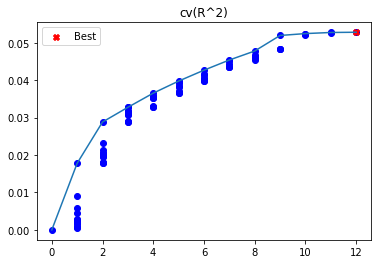

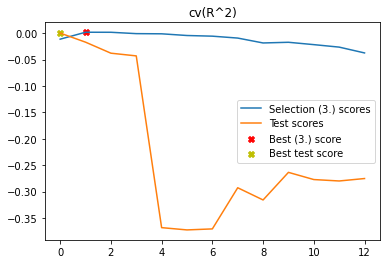

In [44]:
cv = 10
sigma = estimate_sigma(X_train_pd, y_train)
forward_selection(X_train_pd, y_train, X_test_pd, y_test,
                  get_evaluator(make_scorer(r2_score)), np.argmax, # 2.b
                  get_cv_evaluator(make_scorer(r2_score)), np.argmax, # 3.
                  get_evaluator(make_scorer(r2_score)), np.argmax, # test
                  candidates_scorer_name="cv(R^2)",
                  subsets_scorer_name="cv(R^2)",
                  verbose=True, weight_step3=10)

The first graph represents the best model according to cross-validated R-squared: the highest, the better. The best model is the one depicted in red, that contains all the features.

The second graph represents the evaluation of the best models both for training and test data, by using the cross-validated R-squared. In this case the best model for training data is the one having one feature, that is month. Indeed this feature was found to be the only one significantly correlated with the outcome, in the preliminary analysis. The best model for test data is again the one having no features.

# Conclusions

The results of our analysis showed that linear regression is not a suitable approach to the proposed problem.
After performing various techniques of subsets selection and the polynomial regression, the results show that the best model is the one with all the variables with degree 1. The output of linear regression model has a very low R squared value of 0.0528 and a MSE of  1.853 with very low level of variance explained by such model. All the variables, except of month, were non-significant and did't explain the behaviour of the outcome. It is thus impossible to make inference with the regression model.

Starting from the dataset, a considerable number of zero-values came to our attention, anticipating that this would be reflected on the scarse accuracy of the linear model. However, the removal of these values would have halved our dataset and would have removed crucial information. In fact, a zero-value of the area represents a fire of small entity, which should be relevant in such analysis.
As future perspective, this particular problem could be solved by means of classication methods, considering the outcome as categorical.
